In [15]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import FLife
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
from scipy.integrate import quad

In [16]:
# Backward compatibility
if np.__version__>='2.0.0':
    trapezoid = np.trapezoid
else:
    trapezoid = np.trapz

# SpectralData object

SpectralData object contains data, required for fatigue-life estimation: power spectral density (PSD), spectral moments, spectral band estimators and others parameters.

SpectralData is instantiated with input parameter:

- input = 'GUI' - PSD is provided by user via GUI (graphically and tabulary)
- input = dictionary with PSD and frequency vector is provided. (keys ``PSD`` and ``f``)
- input = dictionary with time history and sampling period is provided. (keys ``time_history`` and ``dt``)

## GUI

Default argument is GUI. User is prompted to enter PSD graphically and/or tabulary.

```python
sd1 = FLife.SpectralData(input='GUI')
sd2 = FLife.SpectralData()
```

![alt text](PSDinput.png)




Stationary Gaussian time-history is generated, if parameters T and fs are provided. Otherwise, time-history is generated subsequently, when Rainflow fatigue-life is calculated. Optional parameter for time-history is random generator instance rg (numpy.random._generator.Generator), which determines phase of random process.



## PSD, frequency vector

PSD and frequency arrays are given as input. Both arrays must be of type np.ndarray.

Stationary Gaussian time-history is generated, if parameters T and fs are provided. Otherwise, time-history is generated subsequently, when Rainflow fatigue-life is calculated. Optional parameter for time-history is random generator instance rg (numpy.random._generator.Generator), which determines phase of random process.

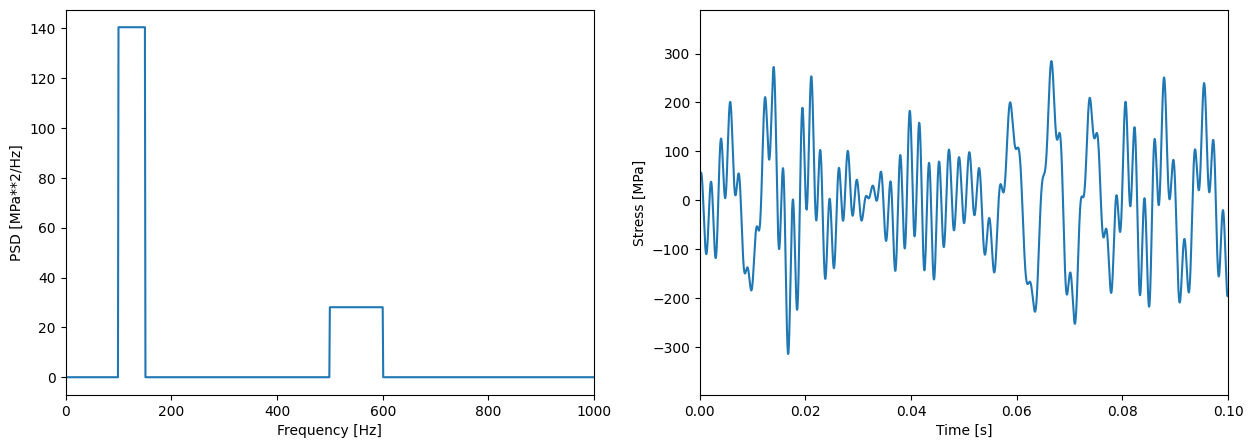

In [35]:
rms = 100  # RMS of random process

seed = 111
rg =  np.random.default_rng(seed)
freq = np.arange(0,1000)

# Bimodal PSD
f_low_LF, f_high_LF = 100, 150 #Low-freqeuncy (LF) component
PSD_LF = np.interp(freq, [f_low_LF, f_high_LF], [1,1], left=0, right=0) 
f_low_HF, f_high_HF = 500, 600 #High-freqeuncy (HF) component
PSD_HF = np.interp(freq, [f_low_HF, f_high_HF], [1/5,1/5], left=0, right=0) 
PSD = PSD_LF + PSD_HF
PSD = PSD/trapezoid(PSD, freq) * rms**2

input_dict = {'PSD': PSD, 'f': freq}
sd3 = FLife.SpectralData(input = input_dict)
# time-history can be generated at SpectralData object instantiation. Sampling frequency `fs` and signal length `T` parameter are needed.
fs = 1e5
sd4 = FLife.SpectralData(input = input_dict, T=1, fs=fs, rg=rg)

time_history_sd4 = sd4.data
# time-history duration and sampling period are dependent on frequency vector length and step
T = sd4.t # time-history duration
dt = sd4.dt # sampling period
time_sd4 = np.arange(0, T, dt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(freq, PSD)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('PSD [MPa**2/Hz]');
ax1.set_xlim(0, 1000)

ax2.plot(time_sd4, time_history_sd4)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Stress [MPa]')
ax2.set_xlim(0, 0.1)

plt.show()

## Time history, dt

Time history x and sampling period dt are given as input. x must be of type np.ndarray and dt of type float, int.

In [26]:
rg =  np.random.default_rng(seed)
time_sd5, signal_sd5 = FLife.tools.random_gaussian(freq=freq, PSD=PSD, T=100, fs=fs, rg=rg)
dt = time_sd5[1]

input_dict = {'time_history': signal_sd5, 'dt': dt}
sd5 = FLife.SpectralData(input=input_dict, nperseg=fs)

# Get PSD data from spectralData object
freq_sd = sd5.psd[:,0]
PSD_sd = sd5.psd[:,1]

Depict PSD and peak amplitude PDF

(0.0, 1000.0)

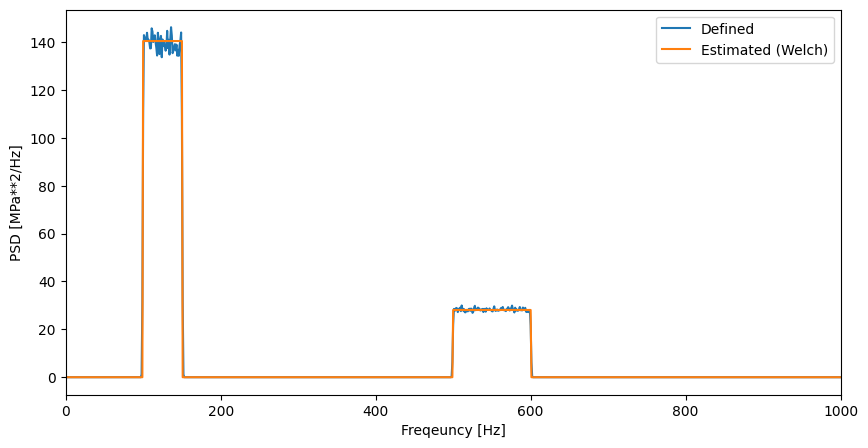

In [36]:
plt.figure(figsize=(10,5))
plt.plot(freq_sd, PSD_sd, label='Defined')
plt.plot(freq, PSD, label='Estimated (Welch)')
plt.legend()
plt.xlabel('Freqeuncy [Hz]')
plt.ylabel('PSD [MPa**2/Hz]');
plt.xlim(0,1000)

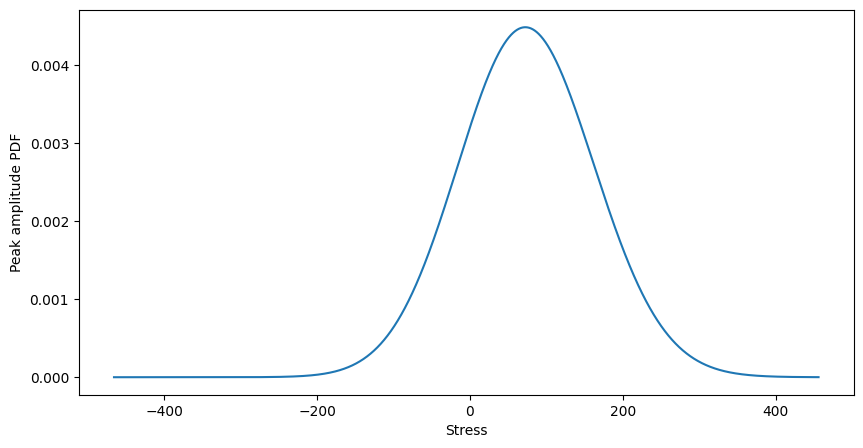

In [28]:
s_rice = np.arange(np.min(sd5.data), np.max(sd5.data), 0.1)

plt.figure(figsize=(10,5))
plt.plot(s_rice, sd5.get_peak_PDF(s_rice))
plt.xlabel('Stress')
plt.ylabel('Peak amplitude PDF')
plt.show()

# Set parameters for fatigue-life estimation and scale the time signal

In [29]:
C = 1.8e+19
k = 6

Instantiation of Fatigue-Life estimation method objects, including Rainflow counting cycle algorithm as reference

In [30]:
# Rainflow reference fatigue life
rf = FLife.Rainflow(sd5)

# Spectral methods
nb = FLife.Narrowband(sd5)
wl = FLife.WirschingLight(sd5)
oc = FLife.OrtizChen(sd5)
a075 = FLife.Alpha075(sd5)
tb = FLife.TovoBenasciutti(sd5)
dk = FLife.Dirlik(sd5)
zb = FLife.ZhaoBaker(sd5)
pk = FLife.Park(sd5)
jp = FLife.JunPark(sd5)
jm = FLife.JiaoMoan(sd5)
so = FLife.SakaiOkamura(sd5)
fc = FLife.FuCebon(sd5)
mfc = FLife.ModifiedFuCebon(sd5)
low_BM = FLife.Low(sd5)
low_2014 = FLife.Low2014(sd5)
gm = FLife.GaoMoan(sd5)
lb = FLife.Lotsberg(sd5)
hm = FLife.HuangMoan(sd5)
sm = FLife.SingleMoment(sd5)
bm = FLife.BandsMethod(sd5)

Check PSD splitting method: equalAreaBands and userDefinedBands

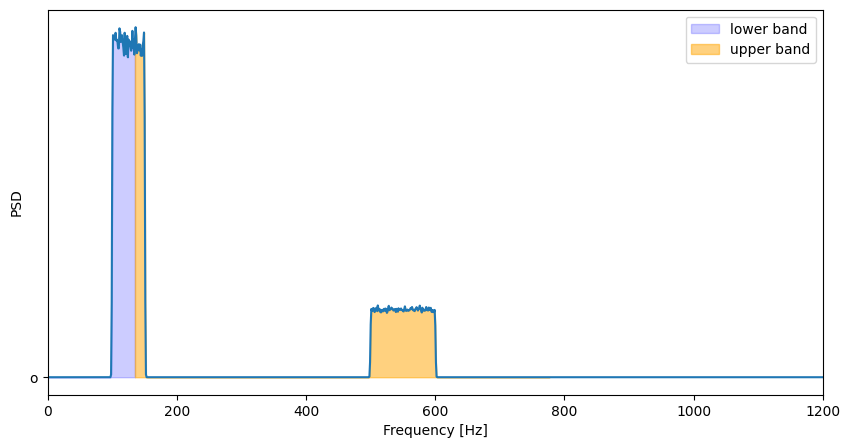

In [31]:
#for Jiao-Moan method, default is `PSD_splitting` = ('equalAreaBands', 2)
lower_band_index, upper_band_index= jm.band_stop_indexes

plt.figure(figsize=(10,5))
plt.plot(sd5.psd[:,0], sd5.psd[:,1])
plt.fill_between(sd5.psd[:lower_band_index+1,0], sd5.psd[:lower_band_index+1,1], 'o', label='lower band', alpha=.2, color='blue')
plt.fill_between(sd5.psd[lower_band_index:upper_band_index+1,0], sd5.psd[lower_band_index:upper_band_index+1,1], 'o', label='upper band', alpha=.5, color ='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.legend();

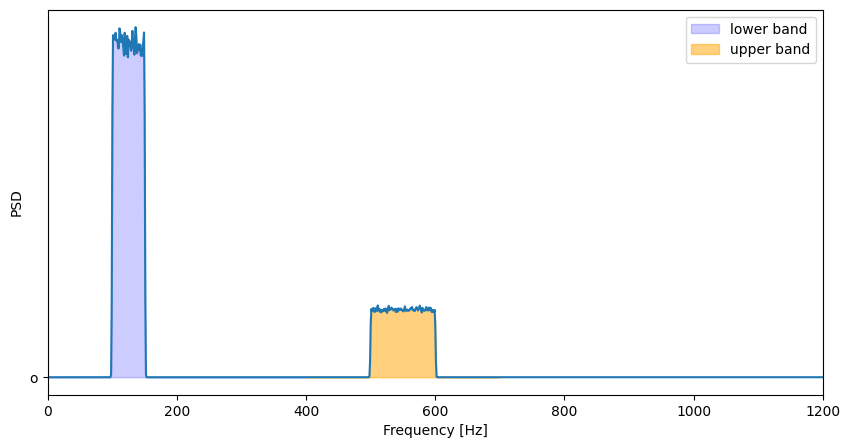

In [32]:
#user defined bands 
jm_userDefinedBands = FLife.JiaoMoan(sd5, PSD_splitting = ('userDefinedBands', [400, 700]))
lower_band_index, upper_band_index= jm_userDefinedBands.band_stop_indexes

plt.figure(figsize=(10,5))
plt.plot(sd5.psd[:,0], sd5.psd[:,1])
plt.fill_between(sd5.psd[:lower_band_index+1,0], sd5.psd[:lower_band_index+1,1], 'o', label='lower band', alpha=.2, color='blue')
plt.fill_between(sd5.psd[lower_band_index:upper_band_index+1,0], sd5.psd[lower_band_index:upper_band_index+1,1], 'o', label='upper band', alpha=.5, color ='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.legend();

Define stress vector and depict stress cycle amplitude PDF

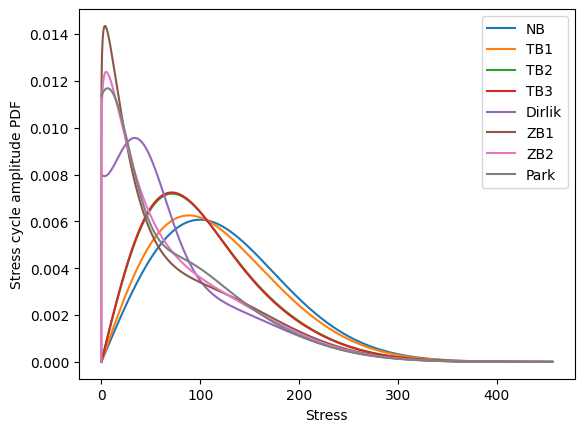

Integrals of PDF should be 1!
         Narrowband:1.000
 Tovo Benasciutti 1:1.000
 Tovo Benasciutti 2:1.000
 Tovo Benasciutti 3:1.000
             Dirlik:1.000
       Zhao Baker 1:1.000
       Zhao Baker 2:1.000
               Park:1.000


In [33]:
s = np.arange(0,np.max(signal_sd5),.001)

#Show PDF functions
plt.plot(s,nb.get_PDF(s), label='NB')
plt.plot(s,tb.get_PDF(s, method='method 1'), label='TB1')
plt.plot(s,tb.get_PDF(s, method='method 2'), label='TB2')
plt.plot(s,tb.get_PDF(s, method='method 3'), label='TB3')
plt.plot(s,dk.get_PDF(s), label='Dirlik')
plt.plot(s,zb.get_PDF(s, method='method 1'), label='ZB1')
plt.plot(s,zb.get_PDF(s, method='method 2'), label='ZB2')
plt.plot(s,pk.get_PDF(s), label='Park')
plt.xlabel('Stress')
plt.ylabel('Stress cycle amplitude PDF')
plt.legend()
plt.show()

#Integral of PDF should be 1!
PDFs = {
    'Narrowband': quad(nb.get_PDF, a=0, b=np.inf)[0],
    'Tovo Benasciutti 1': quad(tb.get_PDF, a=0, b=np.inf, args=('method 1',))[0],
    'Tovo Benasciutti 2': quad(tb.get_PDF, a=0, b=np.inf, args=('method 2',))[0],
    'Tovo Benasciutti 3': quad(tb.get_PDF, a=0, b=np.inf, args=('method 3',))[0],
    'Dirlik': quad(dk.get_PDF, a=0, b=np.inf)[0],
    'Zhao Baker 1': quad(zb.get_PDF, a=0, b=np.inf, args=('method 1',))[0],
    'Zhao Baker 2': quad(zb.get_PDF, a=0, b=np.inf, args=('method 2',))[0],
    'Park': quad(pk.get_PDF, a=0, b=np.inf)[0], 
    #'Jun Park': quad(jp.get_PDF, a=0, b=np.inf)[0] # Correction factor scales the PDF
}

print('Integrals of PDF should be 1!')
for method, value in PDFs.items():
    print(f'{method:>19s}:{value:.3f}')


Estimate Fatigue Life via closed-loop expression and PDF integration

In [34]:
results = {
    'Rainflow': rf.get_life(C=C, k=k, algorithm='four-point'),
    'Rainflow-Low bimodal': rf.get_life(C=C, k=round(k), algorithm='four-point'),
    'Narrowband': nb.get_life(C=C, k=k),
    'Wirsching Light': wl.get_life(C=C, k=k),
    'Ortiz Chen': oc.get_life(C=C, k=k),
    'Alpha 0.75': a075.get_life(C=C, k=k),
    'Tovo Benasciutti 1': tb.get_life(C=C, k=k, method='method 1'),
    'Tovo Benasciutti 2': tb.get_life(C=C, k=k, method='method 2'),
    'Tovo Benasciutti 3': tb.get_life(C=C, k=k, method='method 3'),
    'Dirlik': dk.get_life(C=C, k=k),
    'Zhao Baker 1': zb.get_life(C=C, k=k),
    'Zhao Baker 2': zb.get_life(C=C, k=k, method='method 2'),
    'Park': pk.get_life(C=C, k=k),
    'Jun Park': jp.get_life(C=C, k=k), 
    'Jiao Moan': jm.get_life(C=C, k=k),
    'Jiao Moan (user defined bands)': jm_userDefinedBands.get_life(C=C, k=k),
    'Sakai Okamura': so.get_life(C=C, k=k),
    'Fu Cebon': fc.get_life(C=C, k=k),
    'Modified Fu Cebon': mfc.get_life(C=C, k=k),
    'Low bimodal': low_BM.get_life(C=C, k=round(k)),
    'Low 2014': low_2014.get_life(C=C, k=k), 
    'Gao Moan': gm.get_life(C=C, k=k),
    'Lotsberg': lb.get_life(C=C, k=k),
    'Huang Moan': hm.get_life(C=C, k=k),
    'Single moment': sm.get_life(C=C, k=k),
    'Bands method': bm.get_life(C=C, k=k)
}


results_via_PDF = {
    'Narrowband': nb.get_life(C = C, k=k, integrate_pdf=True),
    'Tovo Benasciutti 1': tb.get_life(C = C, k=k, method='method 1', integrate_pdf=True),
    'Tovo Benasciutti 2': tb.get_life(C = C, k=k, method='method 2', integrate_pdf=True),
    'Tovo Benasciutti 3': tb.get_life(C = C, k=k, method='method 3', integrate_pdf=True),
    'Dirlik': dk.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 1': zb.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 2': zb.get_life(C = C, k=k, method='method 2', integrate_pdf=True),
    'Park': pk.get_life(C = C, k=k, integrate_pdf=True),
    'Jun Park': jp.get_life(C=C, k=k, integrate_pdf=True) 
}

print('Comparison of fatigue life')
for method, value in results.items():
    err = FLife.tools.relative_error(value, results['Rainflow'])
    via_PDF = ''
    if method in results_via_PDF:
        via_PDF = f' (via PDF: {results_via_PDF[f"{method}"]:6.0f} s)'
    print(f'{method:>30s}:{value:6.0f} s,{100*err:>4.0f} % to {"Rainflow"}{via_PDF}')

Comparison of fatigue life
                      Rainflow:  1434 s,   0 % to Rainflow
          Rainflow-Low bimodal:  1434 s,   0 % to Rainflow
                    Narrowband:  1204 s, -16 % to Rainflow (via PDF:   1204 s)
               Wirsching Light:  1654 s,  15 % to Rainflow
                    Ortiz Chen:  1688 s,  18 % to Rainflow
                    Alpha 0.75:  1618 s,  13 % to Rainflow
            Tovo Benasciutti 1:  1348 s,  -6 % to Rainflow (via PDF:   1354 s)
            Tovo Benasciutti 2:  1873 s,  31 % to Rainflow (via PDF:   1908 s)
            Tovo Benasciutti 3:  1905 s,  33 % to Rainflow (via PDF:   1943 s)
                        Dirlik:  1753 s,  22 % to Rainflow (via PDF:   1753 s)
                  Zhao Baker 1:  1496 s,   4 % to Rainflow (via PDF:   1496 s)
                  Zhao Baker 2:  1620 s,  13 % to Rainflow (via PDF:   1620 s)
                          Park:  1744 s,  22 % to Rainflow (via PDF:   1744 s)
                      Jun Park:  1728 s,  21 %